
### Deep Reconstruction-Classification Networks for Unsupervised Domain Adaptation (DRCN) ###

This code is an implementation in pytorch of the DRCN algorithm presented in [1], as applied to transferring results from SVHN to MNIST. A similar implementation exists at [2]. I have been unable to replicate Ghifary et al.'s results, but have reached results similar to [2]

[1] M. Ghifary, W. B. Kleijn, M. Zhang, D. Balduzzi, and W. Li. "Deep Reconstruction-Classification Networks for Unsupervised Domain Adaptation (DRCN)", European Conference on Computer Vision (ECCV), 2016

[2] https://github.com/fungtion/DRCN

First, clone the git repository to obtain the necessary modules

In [1]:
import sys, os

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    os.system("git clone https://github.com/pmirallesr/DRCN-Torch")
    os.system("cd DRCN-Torch")
    sys.path.append("/content/DRCN-Torch")
else:
    parent_dir_path = os.path.abspath(os.path.join(".."))
    if not (parent_dir_path in sys.path):
        sys.path.append(parent_dir_path)
# The last item in the list should be something/DRCN-Torch. If it isn't the imports will fail
print(sys.path)

['/home/pmirallesr/Documents/DRCN-Torch/demos', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/pmirallesr/.local/lib/python3.8/site-packages', '/home/pmirallesr/Documents/gym-duckietown', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/pmirallesr/.local/lib/python3.8/site-packages/IPython/extensions', '/home/pmirallesr/.ipython', '/home/pmirallesr/Documents/DRCN-Torch']


## INITIALIZATION ##

In [2]:
# Imports
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import time  # To time performance
from itertools import product
from data.data_transforms import ImpulseDenoising, GaussianDenoising
from models.DRCN import Encoder, Autoencoder, Labeller
from utils.utils import (
    set_seeds,
    imshow,
    calc_experiments_amount,
    create_exp_name,
    weights_init,
    get_labelling_accuracy,
)
import tensorflow as tf  # Good for logging experiments
import datetime  # Good for naming stuff
from torchsummary import summary  # Good for understanding our network

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Set this to false if you don't want a tensorboard log to be recorded
record_run = False

## Hyperparameters ##
use the dictionary experiment_ranges to define series of experiments to be run
lossControlPenalty is the lambda parameter in the original DRCN paper and trades-off autoencoder loss vs labeller loss.

In [5]:
# Hyperparameters
nb_epochs = 50
train_batch_size = 64
test_batch_size = 64

dropout_chance = 0.5
dense_layer_neurons = 1024
loss_control_penalty = 0.7  # controlPenalty = 0.4...0.7
source_dataset = "SVHN"
target_dataset = "MNIST"
optimizer_name = "RMSProp"  # Adam or RMSProp
source_channels = 1

# experiment_ranges[variable] = [val1, val2] sets up an experiment with val1, val 2.
# All cross combination possibilities of experiment ranges will be used.
# variable = valX sets the variable to that value instead, no experimenting.
# They may both be used simulatenously, but experiment_ranges[var] overrides var
# The total number of experiments is product(len(experiment_ranges[var])) over all vars
# in experiment_ranges, or 1 if experiment_ranges is empty.
# experiment_ranges[var] = val1 and var = val1 are functionally dentical statements
experiment_ranges = {}
experiment_ranges["loss_control_penalty"] = [0.7]
experiment_ranges["dense_layer_neurons"] = [1024]

alpha = 0.9  # Only relevant for RMSProp, smoothing constant for weight update
base_learningRate = 5e-6
experiment_ranges["learningRate"] = [1e-4]
experiment_ranges["weight_decay"] = [5e-6]

data_path = os.path.dirname(os.getcwd()) + "/data/"
log_dir = os.path.dirname(os.getcwd()) + "/logs/"

random_seed = 1905

In [6]:
# Sets all seeds to the chosen number
set_seeds(random_seed)
# If we wanna keep tensorboard logs
if record_run:
    # Creates the logging directory
    os.makedirs(log_dir, exist_ok=True)
    # Creates this experiment's log directory
    experiment_log_dir = log_dir + "/" + create_exp_name(experiment_ranges)
    os.makedirs(experiment_log_dir, exist_ok=True)
    f = open(experiment_log_dir + "experiment_ranges.txt", "w")
    f.write(str(experiment_ranges))
    f.close()

## DATA LOADING ##

We apply several transformations to both MNIST and SVHN

Both datasets are augmented with random rotations of 20 degrees. The original paper also called for random translations of 20% of the image's width, and randomly dropping pixels of each image with a 50% chance per pixel (Impulse noise)

Additionally SVHN is grayscaled and MNIST is rescaled to 32x32 pixels through a bilinear interpolation

In [7]:
# ## DATA LOADING ##
#
# We apply several transformations to both MNIST and SVHN
#
# Both datasets are augmented with random rotations of 20 degrees. The original paper also called for random translations of 20% of the image's width, and randomly dropping pixels of each image with a 50% chance per pixel (Impulse noise)
#
# Additionally SVHN is grayscaled and MNIST is rescaled to 32x32 pixels through a bilinear interpolation


# Data Transforms

# image data augments are performed on all images before they're transformed to tensors
# tensor data augments are performed on all images after they're transformed to tensors
# MNIST / SVHN transforms are performed only on MNIST / SVHN data, and include a toTensor transformation

# Data Augmentation - Geometric Transformations
# 20º random rotation
# 20% random height and width shifts
image_data_augment_transforms = []
# image_data_augment_transforms.append(torchvision.transforms.RandomAffine(degrees = 20))
# image_data_augment_transforms.append(torchvision.transforms.RandomAffine(degrees = 20, translate = (0.2, 0.2)))

# Denoising
tensor_data_augment_transforms = []
# tensor_data_augment_transforms.append(ImpulseDenoising())
# tensor_data_augment_transforms.append(GaussianDenoising(0.2, multiplicative))


MNIST_transforms = []
MNIST_transforms.append(
    torchvision.transforms.Resize((32, 32), interpolation=2)
)  # Rescale to SVHN size
MNIST_transforms.append(torchvision.transforms.ToTensor())

SVHN_transforms = []
SVHN_transforms.append(torchvision.transforms.Grayscale())
SVHN_transforms.append(torchvision.transforms.ToTensor())

In [8]:
# Create the data loaders

train_MNIST_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=True,
        download=True,
        transform=torchvision.transforms.Compose(
            image_data_augment_transforms
            + MNIST_transforms
            + tensor_data_augment_transforms
        ),
    ),
    batch_size=train_batch_size,
    shuffle=True,
)

test_MNIST_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        data_path,
        train=False,
        download=True,
        transform=torchvision.transforms.Compose(MNIST_transforms),
    ),
    batch_size=test_batch_size,
    shuffle=True,
)

# DataLoader has irregular behaviour, does not autom create an SVHN folder but does so for MNIST
train_SVHN_loader = torch.utils.data.DataLoader(
    torchvision.datasets.SVHN(
        data_path + "SVHN/",
        split="train",
        download=True,
        transform=torchvision.transforms.Compose(
            image_data_augment_transforms
            + SVHN_transforms
            + tensor_data_augment_transforms
        ),
    ),
    batch_size=train_batch_size,
    shuffle=True,
)

test_SVHN_loader = torch.utils.data.DataLoader(
    torchvision.datasets.SVHN(
        data_path + "SVHN/",
        split="test",
        download=True,
        transform=torchvision.transforms.Compose(SVHN_transforms),
    ),
    batch_size=test_batch_size,
    shuffle=True,
)


Using downloaded and verified file: /home/pmirallesr/Documents/DRCN-Torch/data/SVHN/train_32x32.mat
Using downloaded and verified file: /home/pmirallesr/Documents/DRCN-Torch/data/SVHN/test_32x32.mat


We show an example batch of both source and target to check the transforms applied

Source Domain batch


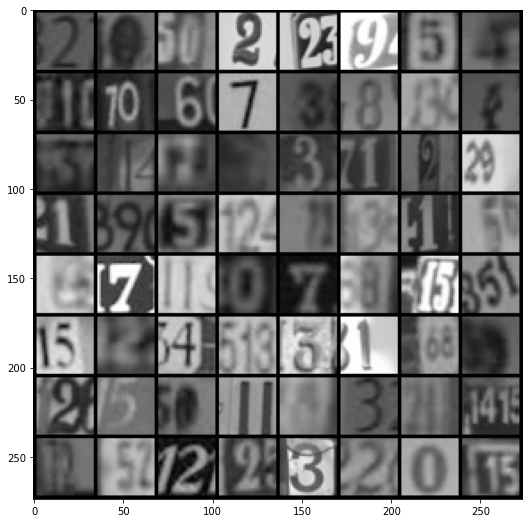

Target Domain batch


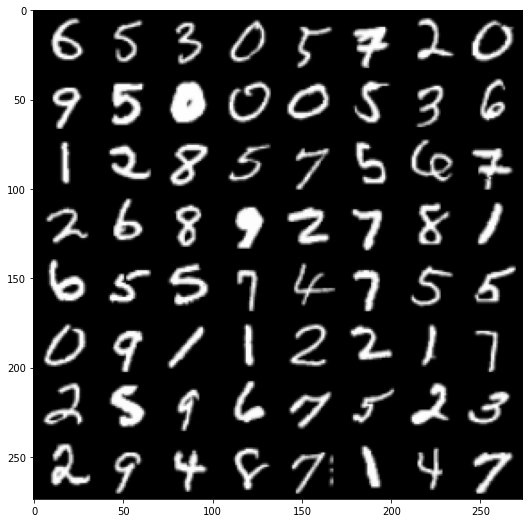

In [9]:
# get some random training images from source
batch_id, (images, labels) = next(enumerate(train_SVHN_loader))
print("Source Domain batch")
imshow(torchvision.utils.make_grid(images))

# get some random training images from target
batch_id, (images, labels) = next(enumerate(train_MNIST_loader))
print("Target Domain batch")
imshow(torchvision.utils.make_grid(images))

In [10]:
def get_settings():
    settings = {}
    settings["optimizer"] = optimizer_name
    settings["learningRate"] = learningRate
    if optimizer_name == "RMSProp":
        settings["weight_decay"] = weight_decay
        settings["alpha"] = alpha
    settings["Epochs"] = nb_epochs
    settings["train_batch_size"] = train_batch_size
    settings["test_batch_size"] = test_batch_size
    settings["dropout_chance"] = dropout_chance
    settings["dense_layer_neurons"] = dense_layer_neurons
    settings["loss_control_penalty"] = loss_control_penalty
    settings["random_seed"] = random_seed
    return settings

## DRCN ##

The architecture of DRCN is simple: An autoencoder and a convolutional labeller with a common encoder body. We alternatively train the autoencoder to reconstruct inputs from the target domain and the labeller to label inputs from the source domain. The network slowly becomes better at both tasks, sacrificing some labelling performance in exchange for some reconstruction performance.

We then take the labeller, trained on the source domain, and apply it to the target domain.

In [11]:
print("-----------------------------------")
print("RECORD RUN IS: {}!!!!".format(record_run))
print("-----------------------------------")
# Create experiments from expRanges configuration dict
experiments = product(*list(experiment_ranges.values()), repeat=1)
# Experiments to be run
total_exp = calc_experiments_amount(experiment_ranges)
start_at_exp = 1  # Controls experiments to be ignored
nb_exp = 0  # experiment counter
# Run all the experiments
for experiment_params in experiments:
    nb_exp += 1
    if nb_exp < start_at_exp:  # Skip already done experiments
        continue
    # Assign and print this experiment's parameters
    for n in range(len(experiment_params)):
        param_name = list(experiment_ranges.keys())[n]
        exec(
            "%s = %f" % (param_name, experiment_params[n])
        )  # Paramname = experiment_params[n]
        print("{}: {}".format(param_name, experiment_params[n]))

    # Run this experiment

    # Create network
    encoder = Encoder(
        source_channels,
        dropout_chance=dropout_chance,
        dense_layer_neurons=int(dense_layer_neurons),
    ).to(device)
    labeller = Labeller(encoder).to(device)
    autoencoder = Autoencoder(encoder).to(device)
    # Custom initialize for conv layers
    autoencoder.apply(weights_init).to(device)

    # Print network summary
    _, (example, _) = next(enumerate(train_SVHN_loader))
    summary(labeller, example.shape[1:])
    summary(autoencoder, example.shape[1:])

    # Init optimizer
    if optimizer_name == "Adam":
        labeller_optimizer = torch.optim.Adam(
            labeller.parameters(), lr=3 * learningRate
        )
        autoencoder_optimizer = torch.optim.Adam(
            autoencoder.parameters(), lr=3 * learningRate
        )
    elif optimizer_name == "RMSProp":
        labeller_optimizer = torch.optim.RMSprop(
            labeller.parameters(),
            lr=learningRate,
            weight_decay=weight_decay,
            alpha=alpha,
        )
        autoencoder_optimizer = torch.optim.RMSprop(
            autoencoder.parameters(),
            lr=learningRate,
            weight_decay=weight_decay,
            alpha=alpha,
        )
    # Init loss criteria
    labeller_criterion = nn.CrossEntropyLoss()
    autoencoder_criterion = nn.MSELoss()

    # Create tensorboard log folder
    log_dir = os.path.dirname(os.getcwd()) + "/logs/" "{}-{}, ".format(
        source_dataset, target_dataset
    ) + "experiment parameters: {}, ".format(experiment_params) + "{} epochs.".format(
        nb_epochs
    ) + datetime.datetime.now().strftime(
        "Date - %Y%m%d-%H%M"
    )
    os.makedirs(log_dir, exist_ok=True)

    # Write settings log
    if record_run:
        f = open(log_dir + "/settings.txt", "w")
        f.write(str(get_settings()))
        f.close()

    # Set train modes
    encoder.train()
    labeller.train()
    autoencoder.train()

    # To keep track of performance during eval
    best_target_accuracy = 0
    best_source_accuracy = 0
    prev_source_train_accuracy = 0
    prev_source_test_accuracy = 0
    prev_target_train_accuracy = 0
    prev_target_test_accuracy = 0

    # To keep timing
    avg_epoch_time = 0
    start = time.time()
    # Verbosity controls
    batches_verbosity = 50

    # More variables for printing advancement and tensorboard
    SVHN_batches = int(73300 / train_batch_size)  # SVHN size
    MNIST_batches = int(60000 / train_batch_size)  # MNIST size
    train_summary_writer = tf.summary.create_file_writer(log_dir)
    test_summary_writer = tf.summary.create_file_writer(log_dir)

    # The nets are evaluated every N periods
    validation_period = 5

    # Start training
    print(
        "Training for {} epochs. Batch size {}, {} and {} batches per epoch of source and target respectively".format(
            nb_epochs, train_batch_size, SVHN_batches, MNIST_batches
        )
    )
    for epoch in range(1, nb_epochs + 1):
        if (epoch % validation_period == 0) or (epoch < validation_period):
            labeller.eval()
            # Start with a t=0 validation run
            print("Validation run")
            print("--------------")
            with torch.no_grad():
                # Log source train accuracy
                (_, _, source_train_accuracy) = get_labelling_accuracy(
                    train_SVHN_loader, labeller
                )
                print(
                    "Accuracy (Train) on SVHN: {:2.2f}%, {:+2.2f}%".format(
                        source_train_accuracy,
                        source_train_accuracy - prev_source_train_accuracy,
                    )
                )
                with train_summary_writer.as_default():
                    tf.summary.scalar(
                        "Source_train_accuracy", source_train_accuracy, epoch
                    )
                prev_source_train_accuracy = source_train_accuracy
                # Log source test accuracy
                (_, _, source_test_accuracy) = get_labelling_accuracy(
                    test_SVHN_loader, labeller
                )
                print(
                    "Accuracy (Test) on SVHN: {:2.2f}%, {:+2.2f}%".format(
                        source_test_accuracy,
                        source_test_accuracy - prev_source_test_accuracy,
                    )
                )
                print(
                    "{:+2.2f}% with respect to maximum of {:2.2f}%".format(
                        source_test_accuracy - best_source_accuracy, best_source_accuracy
                    )
                )
                if source_test_accuracy > best_source_accuracy:
                    print("Best accuracy on source so far!")
                    best_source_accuracy = source_test_accuracy
                    best_source_accuracy_settings = get_settings()
                with test_summary_writer.as_default():
                    tf.summary.scalar(
                        "Source_test_accuracy", source_test_accuracy, epoch
                    )
                prev_source_test_accuracy = source_test_accuracy
                # Log target train accuracy
                (_, _, target_train_accuracy) = get_labelling_accuracy(
                    train_MNIST_loader, labeller
                )
                print(
                    "Accuracy (Train) on MNIST: {:2.2f}%, {:+2.2f}%".format(
                        target_train_accuracy,
                        target_train_accuracy - prev_target_train_accuracy,
                    )
                )
                with train_summary_writer.as_default():
                    tf.summary.scalar(
                        "Target_train_accuracy", target_train_accuracy, epoch
                    )
                prev_target_train_accuracy = target_train_accuracy
                # Log target test accuracy
                (_, _, target_test_accuracy) = get_labelling_accuracy(
                    test_MNIST_loader, labeller
                )
                print(
                    "Accuracy (Test) on MNIST: {:2.2f}%, {:+2.2f}%".format(
                        target_test_accuracy,
                        target_test_accuracy - prev_target_test_accuracy,
                    )
                )
                print(
                    "{:+2.2f}% gap with respect to maximum of {:2.2f}%".format(
                        target_test_accuracy - best_target_accuracy,
                        best_target_accuracy,
                    )
                )
                if target_test_accuracy > best_target_accuracy:
                    print("Best accuracy on target so far!")
                    best_target_accuracy = target_test_accuracy
                    best_target_accuracy_settings = get_settings()
                with test_summary_writer.as_default():
                    tf.summary.scalar(
                        "Target_test_accuracy", target_test_accuracy, epoch
                    )
                prev_target_test_accuracy = target_test_accuracy

            labeller.train()
        print("--------------")

        # Timekeeping
        epoch_start = time.time()

        # Train on target dataset
        print("Target")
        for batch_id, (data, target) in enumerate(train_MNIST_loader):
            autoencoder_optimizer.zero_grad()
            autoencoder.zero_grad()
            encoder.zero_grad()
            data = data.to(device)
            target = target.to(device)
            forward = autoencoder(data)
            data = torch.tensor(data, dtype=torch.double, requires_grad=True).to(device)
            autoencoder_loss = autoencoder_criterion(forward, data)
            autoencoder_loss *= 1 - loss_control_penalty

            # Log performance to tensorboard
            with train_summary_writer.as_default():
                index = epoch * MNIST_batches + batch_id
                tf.summary.scalar("Autoencoder_Loss", autoencoder_loss.item(), index)
            if batch_id % batches_verbosity == 0:
                print(
                    "Target batch {}, epoch {}. Loss = {:.5f}".format(
                        batch_id, epoch, autoencoder_loss.item()
                    )
                )
            autoencoder_loss.backward()
            autoencoder_optimizer.step()

        # Train on source dataset
        print("Source")
        for batch_id, (data, target) in enumerate(train_SVHN_loader):
            labeller_optimizer.zero_grad()
            labeller.zero_grad()
            encoder.zero_grad()
            data = data.to(device)
            target = target.to(device)
            forward = labeller(data).to(device)
            labeller_loss = labeller_criterion(forward, target)
            labeller_loss *= loss_control_penalty  # Apply the loss control penalty

            # Log performance to tensorboard
            with train_summary_writer.as_default():
                index = epoch * SVHN_batches + batch_id
                tf.summary.scalar("Labeller Loss", labeller_loss.item(), index)
            if batch_id % batches_verbosity == 0:
                print(
                    "Source batch {}, epoch {}. Loss = {:.5f}".format(
                        batch_id, epoch, labeller_loss.item()
                    )
                )
            labeller_loss.backward()
            labeller_optimizer.step()

        # Timekeeping and print advancement
        epoch_end = time.time()
        avg_epoch_time = (
            avg_epoch_time * (epoch - 1) + (epoch_end - epoch_start)
        ) / epoch
        print("--------------")
        print("Experiment: {}/{}".format(nb_exp, total_exp))
        print(
            "Epoch {}/{} completed in {:.5f} minutes".format(
                epoch, nb_epochs, (epoch_end - epoch_start) / 60
            )
        )
        print("{:.3f} minutes elapsed".format((epoch_end - start) / 60))
        print(
            "{:.2f} minutes remaining".format(avg_epoch_time / 60 * (nb_epochs - epoch))
        )
        print("--------------")


print("DONE!")
    

-----------------------------------
RECORD RUN IS: False!!!!
-----------------------------------
loss_control_penalty: 0.7
dense_layer_neurons: 1024
learningRate: 0.0001
weight_decay: 5e-06
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 100, 32, 32]           2,600
         MaxPool2d-2          [-1, 100, 16, 16]               0
            Conv2d-3          [-1, 150, 16, 16]         375,150
         MaxPool2d-4            [-1, 150, 8, 8]               0
            Conv2d-5            [-1, 200, 8, 8]         270,200
            Linear-6                 [-1, 1024]      13,108,224
         Dropout2d-7                 [-1, 1024]               0
            Linear-8                 [-1, 1024]       1,049,600
         Dropout2d-9                 [-1, 1024]               0
          Encoder-10                 [-1, 1024]               0
           Linear-11                   [-

KeyboardInterrupt: 

In [ ]:
exp_name = create_exp_name(experiment_ranges)
if exp_name == "":
    exp_name = "no_name"
# exp_name = "Baseline" #zip name override

if IN_COLAB:
    logsFolder = "{}.zip".format(zip_name)
    os.system("zip -r $logsFolder /logs/")
    from google.colab import files
    files.download("/content/" + logsFolder)